In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score

from scipy import stats

In [3]:
def metrics(df, preds, group_by=None):
    true_col = 'entailment'
    
    def get_metrics(y_true, y_pred):
        return {
            'MCC': matthews_corrcoef(y_true, y_pred),
            'Accuracy': accuracy_score(y_true, y_pred),
            'F1': f1_score(y_true, y_pred, average='weighted')
        }
    
    results = []
    
    if group_by not in ['dataset', 'task']:
        for col in preds:
            metrics = get_metrics(df[true_col], df[col])
            metrics['Column'] = col
            results.append(metrics)
    else:
        for col in preds:
            for group_name, group in df.groupby(group_by):
                metrics = get_metrics(group[true_col], group[col])
                metrics['Column'] = col
                metrics[group_by.capitalize()] = group_name
                results.append(metrics)
    
    results_df = pd.DataFrame(results)
    
    if group_by in ['dataset', 'task']:
        return results_df.set_index(['Column', group_by.capitalize()])
    else:
        return results_df.set_index('Column')

In [5]:
# import data
df = pd.read_csv('../data/mcc_matrix.csv')
# subset to columns included in the plot
# Combine the two dataframes for easy plotting
# subset to desired models
# rename models for plotting
df.replace({'NLI Base': 'DeBERTa Base', 
            'NLI Large':'DeBERTa Large', 
            'PolNLI Base':'DEBATE Base',
            'Llama 3.1 8B':'Llama 3.1',
            'PolNLI Large':'DEBATE Large',
            'Claude 3.5 Sonnet':'Claude 3.5'
           }, inplace = True)

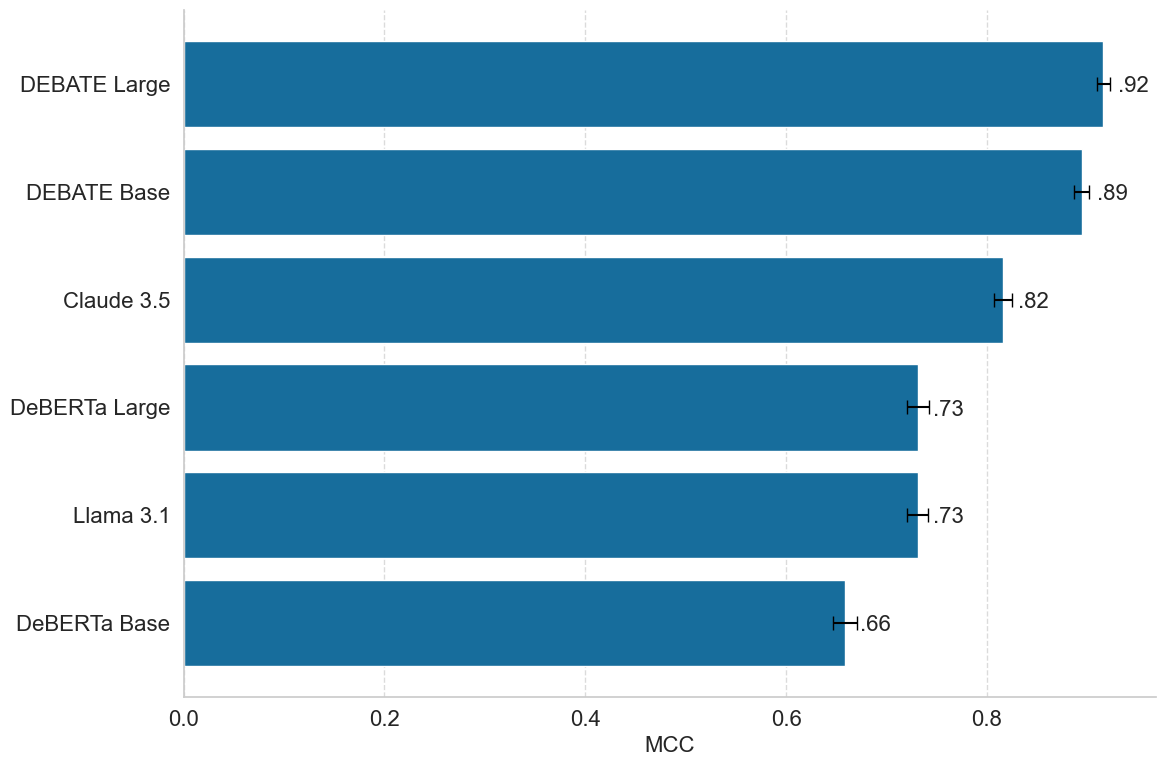

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

data = df[df['task'] == 'overall']
# Sort the dataframe by MCC values in descending order
data = data.sort_values('mcc', ascending=False)
data.reset_index(drop = True, inplace = True)
# Set the style and font scale
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

custom_palette = sns.color_palette("colorblind", len(data['task'].unique()))

# Create the bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='mcc', 
                 y='model', 
                 data=data, 
                 hue = 'task',
                 palette=custom_palette,
                 orient='h')

# Add error bars
plt.errorbar(x=data['mcc'], y=data.index, xerr=[data['mcc'] - data['lower'], data['upper'] - data['mcc']],
             fmt='none', ecolor='black', capsize=5)

# Add MCC values at the end of bars
for i, v in enumerate(data['mcc']):
    ax.text(v+.015, i+.02, f'{v:.2f}'.lstrip('0'), va='center', fontsize=16)

# Customize the plot
plt.xlabel('MCC', fontsize=16)
plt.ylabel('')  # Remove y-axis label

# Increase font size of tick marks
plt.tick_params(axis='both', which='major', labelsize=16)

# Adjust the x-axis limit to accommodate the text
#plt.xlim(0, max(data['mcc']) * 1.1)

# Remove top and right spines
sns.despine(top=True, right=True)

# Remove vertical grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='')
legend = plt.legend()
legend.remove()

# Show the plot
plt.tight_layout()
plt.savefig('plots/test_overall.png')
plt.show()

# By Task

/var/folders/1q/xggcl4hn6mx_q8dfxbx_whpr0000gq/T/ipykernel_89559/2642133838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace({'DeBERTa Base': 'DeBERTa\nBase',
/var/folders/1q/xggcl4hn6mx_q8dfxbx_whpr0000gq/T/ipykernel_89559/2642133838.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['model'] = pd.Categorical(data['model'], categories=modelorder, ordered=True)
/var/folders/1q/xggcl4hn6mx_q8dfxbx_whpr0000gq/T/ipykernel_89559/2642133838.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

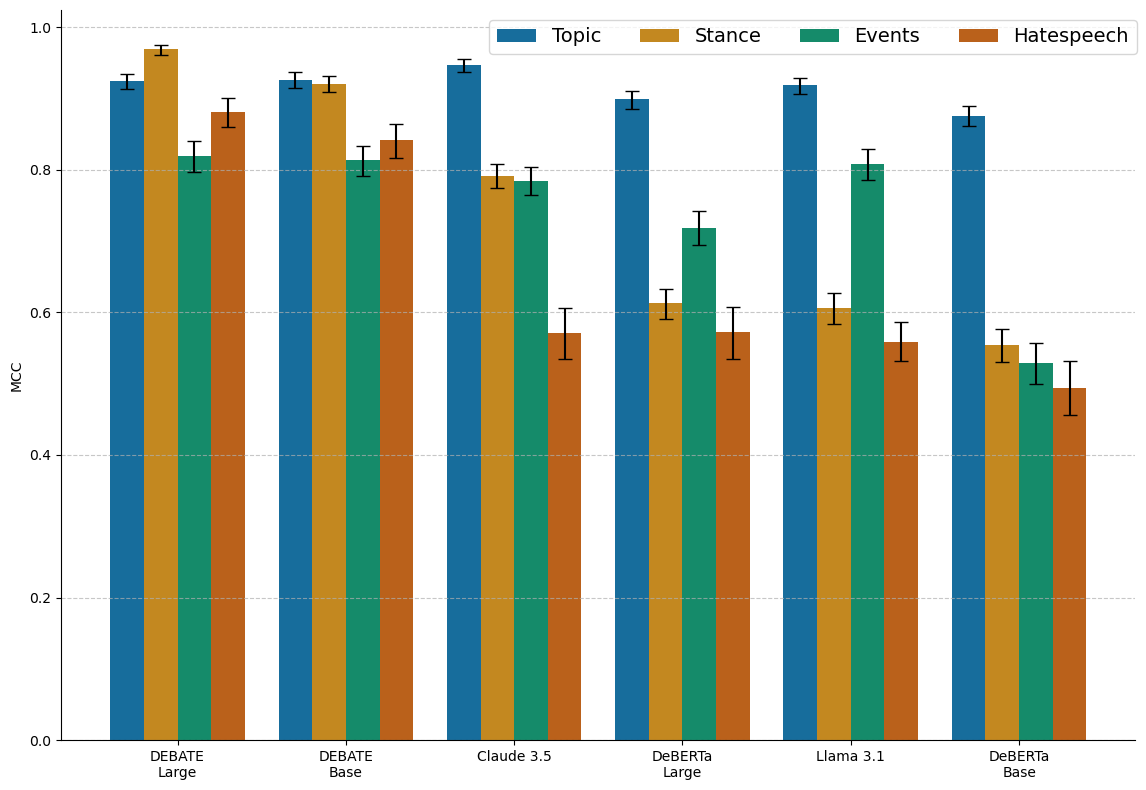

In [6]:
data = df[df['task'] != 'overall']

data.replace({'DeBERTa Base': 'DeBERTa\nBase', 
            'DeBERTa Large':'DeBERTa\nLarge', 
            'DEBATE Base':'DEBATE\nBase',
            'Llama 3.1 8B':'Llama 3.1',
            'DEBATE Large':'DEBATE\nLarge',
            'Claude 3.5 Sonnet':'Claude 3.5',
              'event extraction': 'Events',
              'hatespeech and toxicity':'Hatespeech',
              'stance detection':'Stance',
              'topic classification':'Topic'
           }, inplace = True)
modelorder = ["DEBATE\nLarge", "DEBATE\nBase", "Claude 3.5", "DeBERTa\nLarge", "Llama 3.1", "DeBERTa\nBase"]
taskorder = ['Topic', 'Stance', 'Events', 'Hatespeech']
data['model'] = pd.Categorical(data['model'], categories=modelorder, ordered=True)
data['task'] = pd.Categorical(data['task'], categories=taskorder, ordered=True)
data = data.sort_values(['task', 'model'])
data.reset_index(drop = True, inplace = True)


# Set the figure size for better visibility
plt.figure(figsize=(12, 8))

custom_palette = sns.color_palette("colorblind", len(data['task'].unique()))

# Create the grouped bar plot
barplot = sns.barplot(
    x="model",
    y="mcc",
    hue="task",
    data=data,
    palette=custom_palette,  # Apply the custom color palette
    errorbar=None  # Disable internal confidence intervals as we're using custom error bars
)

# Get the x positions of the bars for alignment
for bar, lower, upper in zip(barplot.patches, data['lower'], data['upper']):
    bar_x = bar.get_x() + bar.get_width() / 2  # Center of the bar
    bar_height = bar.get_height()
    # Plot the error bars
    plt.errorbar(
        x=bar_x,
        y=bar_height,
        yerr=[[bar_height - lower], [upper - bar_height]],
        fmt='none',  # No marker
        capsize=5,   # Length of the error bar caps
        color='black'
    )

# Remove X-axis label and eliminate rotation
plt.xlabel('')
plt.xticks(rotation=0)
plt.legend(title='', fontsize=14, ncol=len(data['task'].unique()), loc='upper center', bbox_to_anchor=(0.7, 1.0))

# Label the Y axis
plt.ylabel('MCC')

# Despine the top and right side, and remove horizontal gridlines
sns.despine(top=True, right=True)
plt.grid(axis='y', which='both', linestyle='--', alpha=0.7)  # Disable horizontal gridlines

# Improve layout
plt.tight_layout()
#plt.savefig('plots/test_tasks.png')
# Show the plot
plt.show()

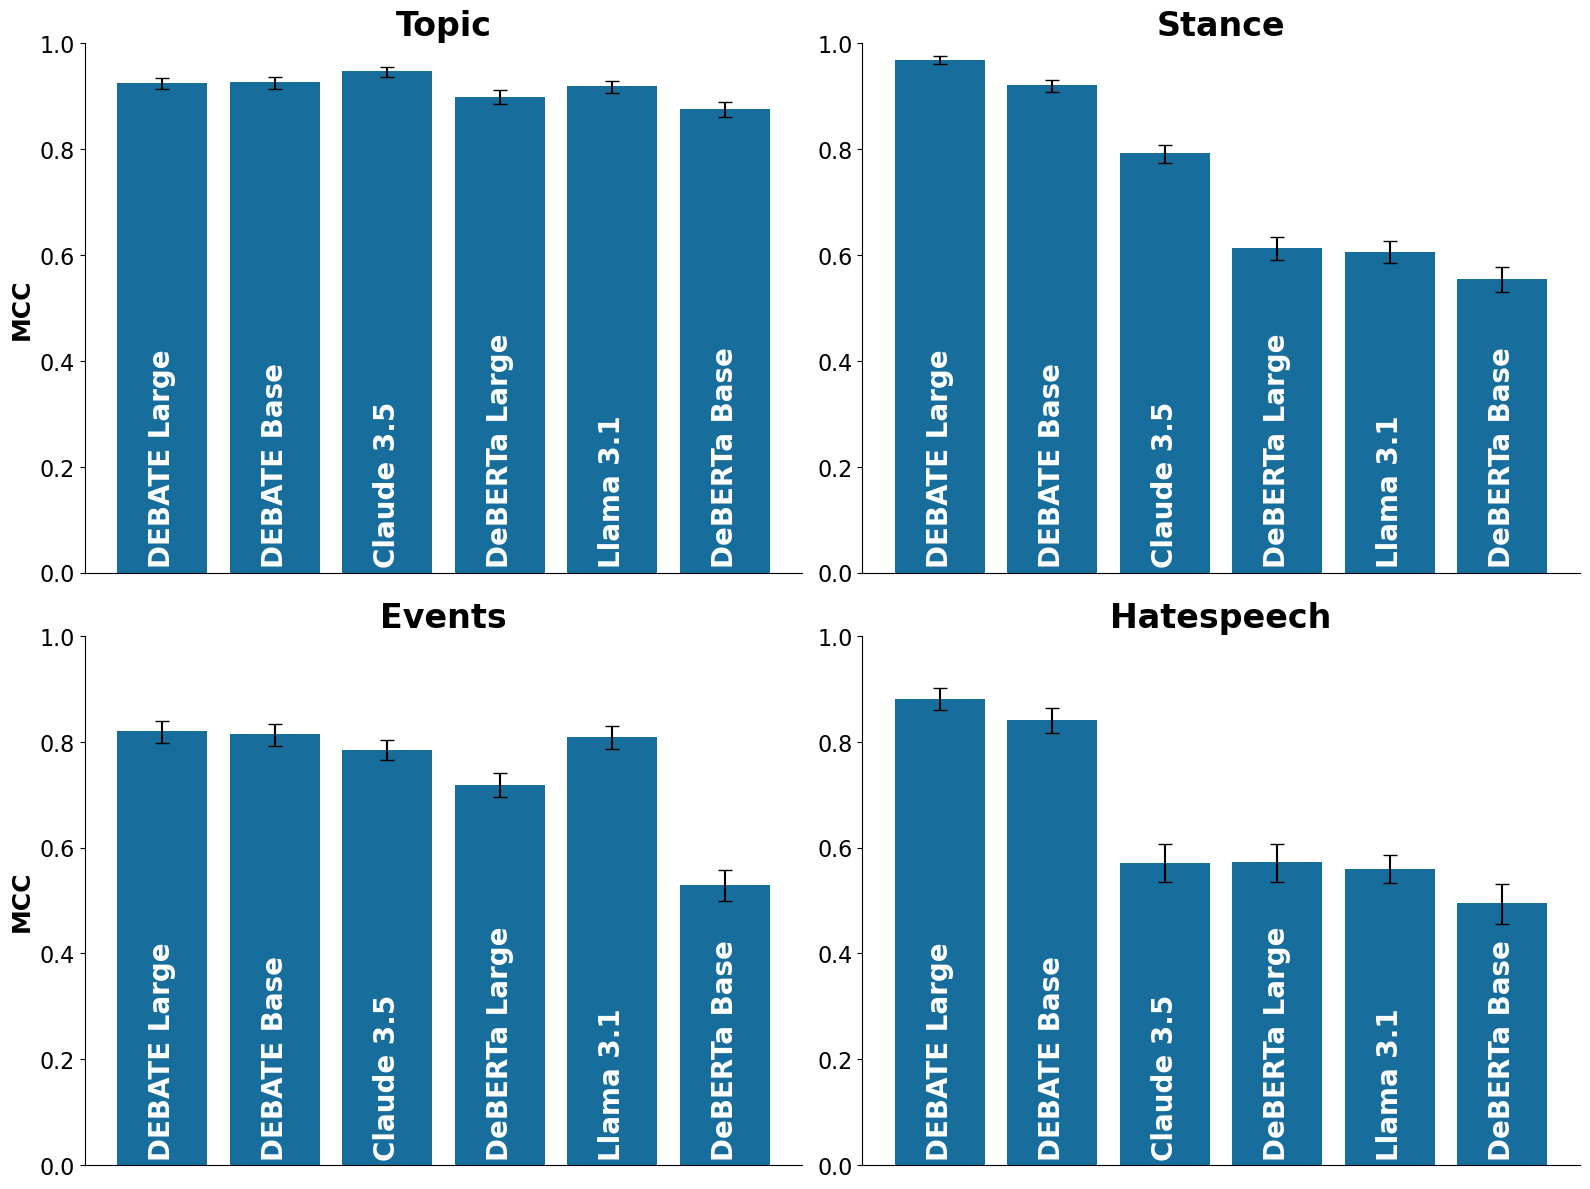

In [80]:
data = df[df['task'] != 'overall'].copy()  # Create a copy to avoid SettingWithCopyWarning
data.replace({'DeBERTa Base': 'DeBERTa Base', 
            'DeBERTa Large':'DeBERTa Large', 
            'DEBATE Base':'DEBATE Base',
            'Llama 3.1 8B':'Llama 3.1',
            'DEBATE Large':'DEBATE Large',
            'Claude 3.5 Sonnet':'Claude 3.5',
              'event extraction': 'Events',
              'hatespeech and toxicity':'Hatespeech',
              'stance detection':'Stance',
              'topic classification':'Topic'
           }, inplace=True)

modelorder = ["DEBATE Large", "DEBATE Base", "Claude 3.5", "DeBERTa Large", "Llama 3.1", "DeBERTa Base"]
taskorder = ['Topic', 'Stance', 'Events', 'Hatespeech']
data['model'] = pd.Categorical(data['model'], categories=modelorder, ordered=True)
data['task'] = pd.Categorical(data['task'], categories=taskorder, ordered=True)
data = data.sort_values(['task', 'model'])
data.reset_index(drop=True, inplace=True)

# Set up the subplot grid
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

# Get the first color from the colorblind palette
bar_color = sns.color_palette("colorblind")[0]

# Create a bar plot for each task
for i, task in enumerate(taskorder):
    task_data = data[data['task'] == task]
    
    # Create the bar plot
    barplot = sns.barplot(
        x="model",
        y="mcc",
        data=task_data,
        color=bar_color,
        errorbar=None,
        ax=axs[i]
    )
    
    # Add error bars and labels inside bars
    for j, (bar, lower, upper, model) in enumerate(zip(barplot.patches, task_data['lower'], task_data['upper'], task_data['model'])):
        bar_x = bar.get_x() + bar.get_width() / 2
        bar_height = bar.get_height()
        
        # Add error bars
        axs[i].errorbar(
            x=bar_x,
            y=bar_height,
            yerr=[[bar_height - lower], [upper - bar_height]],
            fmt='none',
            capsize=5,
            color='black'
        )
        
        # Add label inside bar
        axs[i].text(bar_x, 0.01, model, ha='center', va='bottom', 
                    rotation=90, color='white', fontweight='bold', fontsize=20)
    
    # Customize each subplot
    axs[i].set_title(task, fontsize=24, fontweight = 'bold')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('MCC' if i % 2 == 0 else '', fontsize = 18, fontweight = 'bold')  # Add y-label only for left subplots
    axs[i].tick_params(axis='both', which='major', labelsize=16)
    axs[i].set_xticks([])  # Remove x-axis ticks
    sns.despine(ax=axs[i], top=True, right=True, bottom=False)  # Remove bottom spine
    #axs[i].grid(axis='y', which='both', linestyle='--', alpha=0.7)
    
    # Set y-axis limit to 1
    axs[i].set_ylim(0, 1)
    
    # Only show y-ticks for left subplots
    #if i % 2 != 0:
    #    axs[i].set_yticks([])

# Adjust layout
plt.tight_layout()
plt.savefig('../plots/test_tasks.png', dpi = 300)
# Show the plot
plt.show()


# By Dataset

In [8]:
df = pd.read_csv('polnli_test_results.csv')

In [9]:
len(df['hypothesis'].unique())

82

In [10]:
data = metrics(df, preds = df.columns[6:], group_by = 'dataset')

In [11]:
data.reset_index(inplace = True)
data['Column'].unique()

array(['base_nli', 'large_nli', 'base_polnli', 'llama', 'large_polnli', 'sonnet'], dtype=object)

In [12]:
data.replace({'base_nli': 'DeBERTa Base', 
            'large_nli':'DeBERTa Large', 
            'base_polnli':'DEBATE Base',
            'llama':'Llama 3.1',
            'large_polnli':'DEBATE Large',
            'sonnet':'Claude 3.5'
           }, inplace = True)

modelorder = ["DEBATE Large", "DEBATE Base", "Claude 3.5", "DeBERTa Large", "Llama 3.1", "DeBERTa Base"]
data['Column'] = pd.Categorical(data['Column'], categories=modelorder, ordered=True)

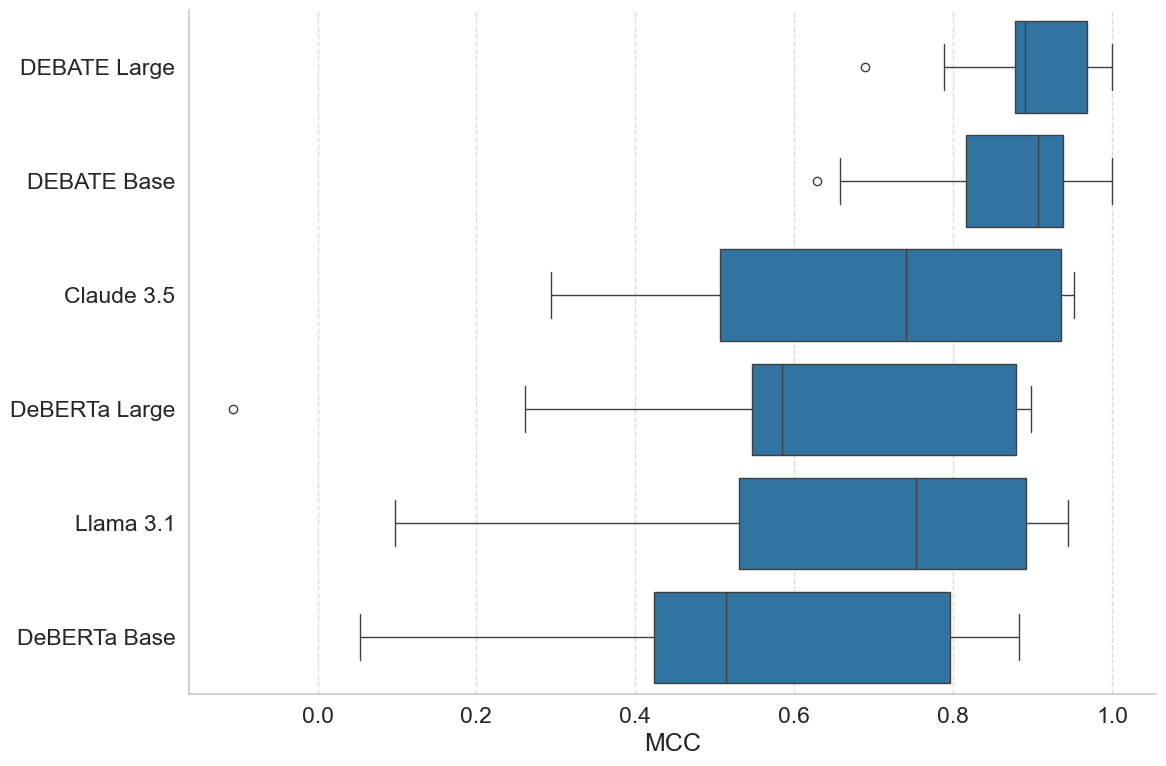

In [13]:
# Set the figure size for better visibility
plt.figure(figsize=(12, 8))

# Create the box plot
sns.boxplot(
    x='MCC',           # X-axis
    y='Column',        # Y-axis
    data=data,         # Your DataFrame
    fill=custom_palette[0]  # Use a colorblind-friendly palette
)
sns.despine(top=True, right=True)
# Label the axes
plt.xlabel('MCC')
plt.ylabel('')
plt.grid(axis='x', which='both', linestyle='--', alpha=0.7)
# Improve layout
plt.tight_layout()
plt.savefig('plots/test_datasets.png')
# Show the plot
plt.show()

# Few Shot

In [299]:
df.groupby('n').agg({'accuracy': ['mean', calculate_ci]}).reset_index()

C:\Users\mikeb\AppData\Local\Temp\ipykernel_6788\2430319109.py:4: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))


n  accuracy                                          
            mean                              calculate_ci
0    0  0.862607                                (nan, nan)
1   10  0.871219  (0.8627173705766075, 0.8797206668538428)
2   25  0.877319     (0.872830310086265, 0.88180781427663)
3   50  0.873671  (0.8640810738959019, 0.8832601754587701)
4  100  0.880975  (0.8737419326407659, 0.8882082528388312)

In [60]:
df = pd.read_csv('motn_fewshot_large.csv')
df.groupby('n').mean()

,mcc,accuracy
n,,
0,0.588539,0.816645
10,0.758550,0.888661
25,0.745886,0.888258
50,0.774674,0.900831
100,0.804872,0.913958


In [57]:
fr = pd.read_csv('motn_fewshot_base.csv')
fr.groupby('n').mean()

,mcc,accuracy
n,,
0,0.560919,0.812320
10,0.708204,0.863176
25,0.727987,0.880289
50,0.757141,0.892322
100,0.785176,0.905113


In [58]:
fr

,n,mcc,accuracy
0,10,0.590186,0.788320
1,10,0.726765,0.870997
2,10,0.723519,0.879265
3,10,0.735581,0.877822
4,10,0.612194,0.790157
5,10,0.739177,0.884514
6,10,0.726060,0.879003
7,10,0.742151,0.887270
8,10,0.764970,0.897113
9,10,0.721437,0.877297


C:\Users\mikeb\AppData\Local\Temp\ipykernel_7496\3559709369.py:5: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))
C:\Users\mikeb\AppData\Local\Temp\ipykernel_7496\3559709369.py:5: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))


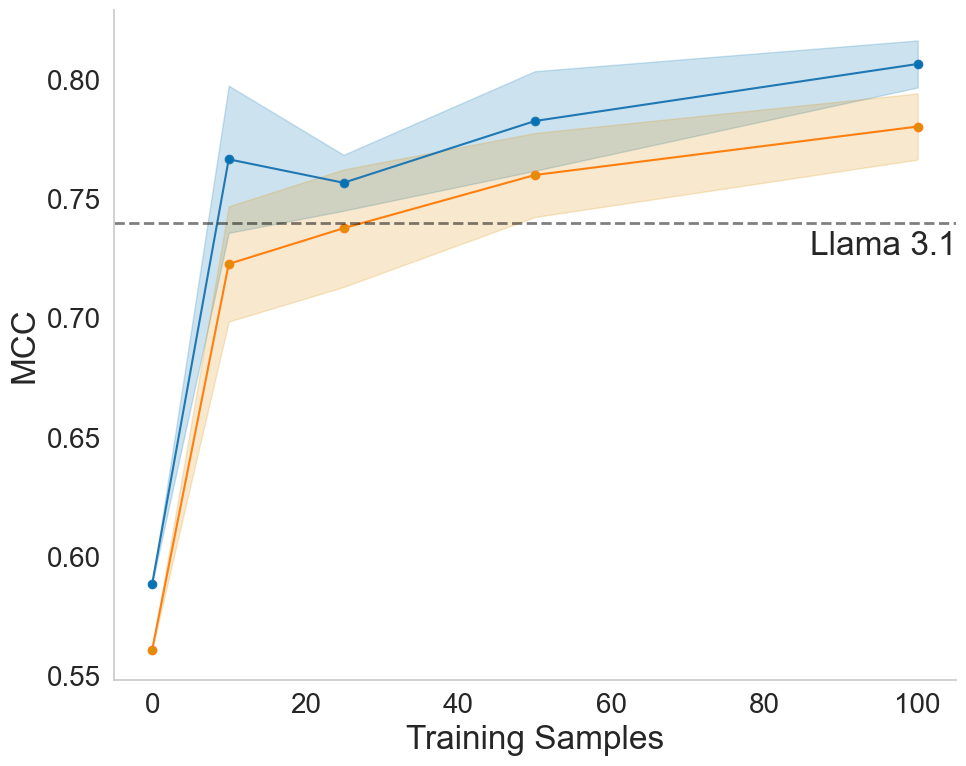

In [82]:
df = pd.read_csv('motn_fewshot_large2.csv')
fr = pd.read_csv('motn_fewshot_base2.csv')
textsize = 24
def calculate_ci(data):
    return stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))

custom_palette = sns.color_palette("colorblind", 2)

# Group by 'n' and calculate mean MCC and confidence intervals for both dataframes
df_grouped = df.groupby('n').agg({'mcc': ['mean', calculate_ci]}).reset_index()
df_grouped.columns = df_grouped.columns.to_flat_index()
df_grouped.columns = ['n', 'mcc_mean', 'ci']
df_grouped['mcc_ci_low'] = [ci[0] for ci in df_grouped['ci']]
df_grouped['mcc_ci_high'] = [ci[1] for ci in df_grouped['ci']]
df_grouped.drop('ci', axis = 1, inplace = True)
df_grouped.fillna(df_grouped[df_grouped['n'] == 0]['mcc_mean'][0], inplace = True)

fr_grouped = fr.groupby('n').agg({'mcc': ['mean', calculate_ci]}).reset_index()
fr_grouped.columns = fr_grouped.columns.to_flat_index()
fr_grouped.columns = ['n', 'mcc_mean', 'ci']
fr_grouped['mcc_ci_low'] = [ci[0] for ci in fr_grouped['ci']]
fr_grouped['mcc_ci_high'] = [ci[1] for ci in fr_grouped['ci']]
fr_grouped.drop('ci', axis = 1, inplace = True)
fr_grouped.fillna(fr_grouped[fr_grouped['n'] == 0]['mcc_mean'][0], inplace = True)

# Create the plot
plt.figure(figsize=(10, 8))
#sns.set_style("whitegrid")

# Plot lines for both dataframes
plt.plot(df_grouped['n'], df_grouped['mcc_mean'], label='DEBATE Large', marker='o', markerfacecolor=custom_palette[0])
plt.plot(fr_grouped['n'], fr_grouped['mcc_mean'], label='DEBATE Base', marker='o', markerfacecolor=custom_palette[1])
sns.despine(top=True, right=True)
# Add confidence intervals
plt.fill_between(df_grouped['n'], df_grouped['mcc_ci_low'], df_grouped['mcc_ci_high'], alpha=0.2, color = custom_palette[0])
plt.fill_between(fr_grouped['n'], fr_grouped['mcc_ci_low'], fr_grouped['mcc_ci_high'], alpha=0.2, color=custom_palette[1])

plt.grid(axis='y', which='both', linestyle='', alpha=0.7)
plt.grid(axis='x', which='both', linestyle='', alpha=0.7)

#plt.axhline(y=0.66, color=custom_palette[0], linestyle='--', linewidth=2, alpha = 0.5)
plt.axhline(y=0.74, color='black', linestyle='--', linewidth=2, alpha = 0.5)

# Add annotations
#plt.text(plt.xlim()[1], 0.653, 'Supervised Transformer', va='center', ha='right')
plt.text(plt.xlim()[1], 0.73, 'Llama 3.1', va='center', ha='right', size = textsize)
plt.tick_params(axis = 'both', labelsize = textsize-4)

# Customize the plot
plt.xlabel('Training Samples', size = textsize)
plt.ylabel('MCC', size = textsize)
plt.title('')
#plt.legend(loc = 'lower right', fontsize = textsize)
plt.tight_layout()
plt.savefig('plots/fewshot_motn.png')
# Show the plot
plt.show()

In [52]:
fr.groupby('n').mean()

,mcc,accuracy
n,,
0,0.209142,0.742828
10,0.310338,0.762367
25,0.444210,0.793731
50,0.546057,0.830098
100,0.581413,0.841229


In [63]:
df.groupby('n').mean()

,mcc,accuracy
n,,
0,0.629658,0.862607
10,0.668466,0.870663
25,0.687157,0.876707
50,0.681714,0.875581
100,0.704320,0.886910


C:\Users\mikeb\AppData\Local\Temp\ipykernel_7496\3448401063.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))
C:\Users\mikeb\AppData\Local\Temp\ipykernel_7496\3448401063.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))


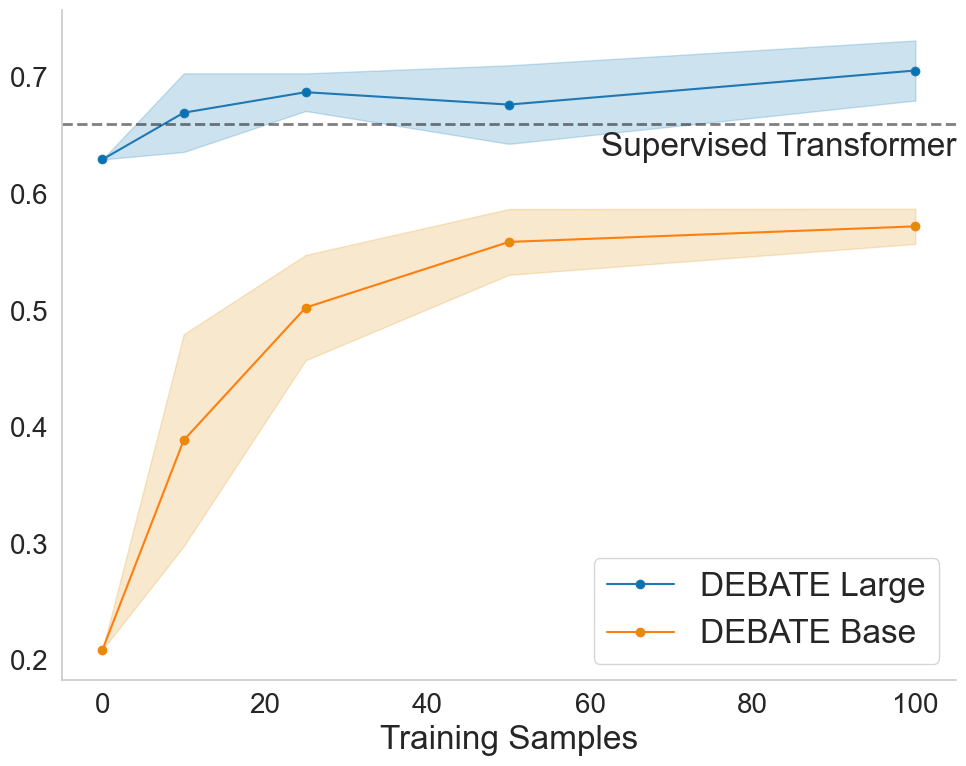

In [83]:
df = pd.read_csv('covid_fewshot_large2.csv')
fr = pd.read_csv('covid_fewshot_base.csv')
#df = pd.read_csv('motn_fewshot_base.csv')
#fr = pd.read_csv('motn_fewshot_large.csv')
textsize = 24
def calculate_ci(data):
    return stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))

custom_palette = sns.color_palette("colorblind", 2)

# Group by 'n' and calculate mean MCC and confidence intervals for both dataframes
df_grouped = df.groupby('n').agg({'mcc': ['mean', calculate_ci]}).reset_index()
df_grouped.columns = df_grouped.columns.to_flat_index()
df_grouped.columns = ['n', 'mcc_mean', 'ci']
df_grouped['mcc_ci_low'] = [ci[0] for ci in df_grouped['ci']]
df_grouped['mcc_ci_high'] = [ci[1] for ci in df_grouped['ci']]
df_grouped.drop('ci', axis = 1, inplace = True)
df_grouped.fillna(df_grouped[df_grouped['n'] == 0]['mcc_mean'][0], inplace = True)

fr_grouped = fr.groupby('n').agg({'mcc': ['mean', calculate_ci]}).reset_index()
fr_grouped.columns = fr_grouped.columns.to_flat_index()
fr_grouped.columns = ['n', 'mcc_mean', 'ci']
fr_grouped['mcc_ci_low'] = [ci[0] for ci in fr_grouped['ci']]
fr_grouped['mcc_ci_high'] = [ci[1] for ci in fr_grouped['ci']]
fr_grouped.drop('ci', axis = 1, inplace = True)
fr_grouped.fillna(fr_grouped[fr_grouped['n'] == 0]['mcc_mean'][0], inplace = True)

# Create the plot
plt.figure(figsize=(10, 8))
#sns.set_style("whitegrid")

# Plot lines for both dataframes
plt.plot(df_grouped['n'], df_grouped['mcc_mean'], label='DEBATE Large', marker='o', markerfacecolor=custom_palette[0])
plt.plot(fr_grouped['n'], fr_grouped['mcc_mean'], label='DEBATE Base', marker='o', markerfacecolor=custom_palette[1])
sns.despine(top=True, right=True)
# Add confidence intervals
plt.fill_between(df_grouped['n'], df_grouped['mcc_ci_low'], df_grouped['mcc_ci_high'], alpha=0.2, color = custom_palette[0])
plt.fill_between(fr_grouped['n'], fr_grouped['mcc_ci_low'], fr_grouped['mcc_ci_high'], alpha=0.2, color=custom_palette[1])

plt.grid(axis='y', which='both', linestyle='', alpha=0.7)
plt.grid(axis='x', which='both', linestyle='', alpha=0.7)

plt.axhline(y=0.66, color='black', linestyle='--', linewidth=2, alpha = 0.5)
#plt.axhline(y=0.74, color=custom_palette[1], linestyle='--', linewidth=2, alpha = 0.5)

# Add annotations
plt.text(plt.xlim()[1], 0.64, 'Supervised Transformer', va='center', ha='right', size = textsize)
plt.tick_params(axis = 'both', labelsize = textsize-4)

# Customize the plot
plt.xlabel('Training Samples', size = textsize)
plt.ylabel('', size = textsize)
plt.title('')
plt.legend(loc = 'lower right', fontsize = textsize)
plt.tight_layout()
plt.savefig('plots/fewshot_covid.png')
# Show the plot
plt.show()

# Timing

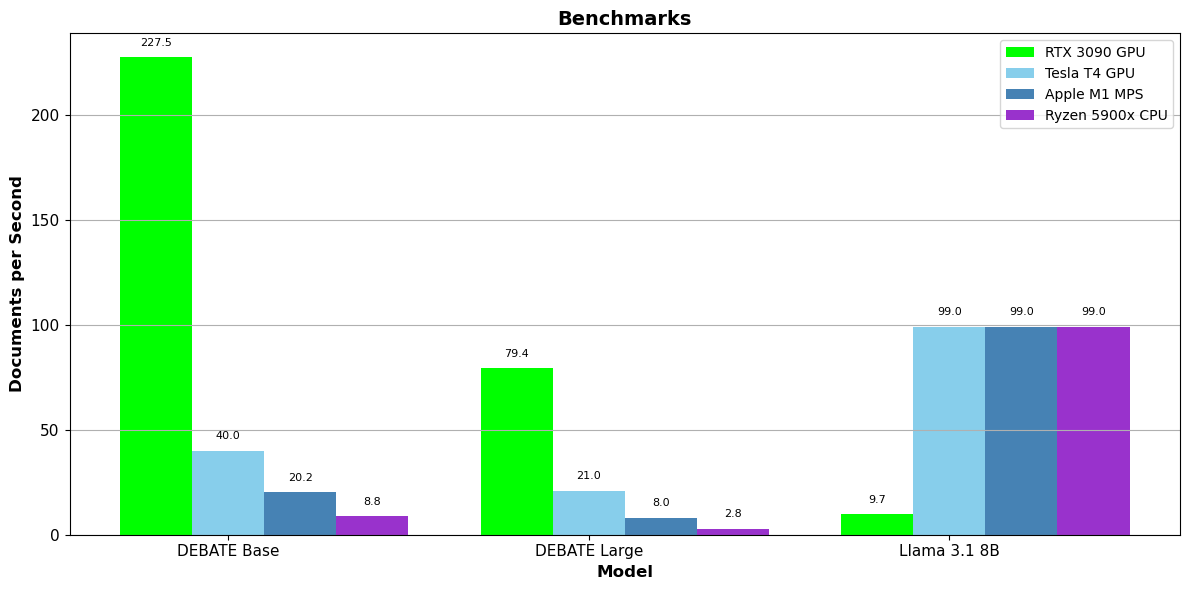

In [2]:
# Create the dataframe
Model = ['DEBATE Base'] * 4 + ['DEBATE Large'] * 4 + ['Llama 3.1 8B'] * 4
Hardware = ['RTX 3090 GPU', 'Tesla T4 GPU', 'Apple M1 MPS', 'Ryzen 5900x CPU'] * 3
Time = [0.37, 2.08, 4.13, 9.42, 1.05, 3.97, 10.48, 29.45, 8.62, 33.33, 33.33, 33.33]
doc_sec = [227.5, 40, 20.2, 8.8, 79.4, 21, 8, 2.8, 9.7, 99, 99, 99]

polnli_df = pd.DataFrame({'Model': Model, 'Hardware': Hardware, 'Time': Time, 'doc_sec': doc_sec})

# Ensure the order of factors
polnli_df['Model'] = pd.Categorical(polnli_df['Model'], categories=['DEBATE Base', 'DEBATE Large', 'Llama 3.1 8B'], ordered=True)
polnli_df['Hardware'] = pd.Categorical(polnli_df['Hardware'], categories=['RTX 3090 GPU', 'Tesla T4 GPU', 'Apple M1 MPS', 'Ryzen 5900x CPU'], ordered=True)

# Create the plot
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = range(len(polnli_df['Model'].unique()))

colors = ['lime', 'skyblue', 'steelblue', 'darkorchid']

for i, hardware in enumerate(polnli_df['Hardware'].unique()):
    data = polnli_df[polnli_df['Hardware'] == hardware]
    bars = plt.bar([x + i*bar_width for x in index], data['doc_sec'], 
                   bar_width, label=hardware, color=colors[i])
    
    # Add text labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 4.5,
                 f'{height}', ha='center', va='bottom', size=8)

plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Documents per Second', fontsize=12, fontweight='bold')
plt.title('Benchmarks', fontsize=14, fontweight='bold')
plt.xticks([x + bar_width for x in index], polnli_df['Model'].unique(), fontsize=11)
plt.yticks(fontsize=11)
plt.legend()

plt.grid(axis='y')
plt.tight_layout()

plt.show()